In [3]:
# General imports 
import os 
import re
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt
import json
import zarr

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

# set paths
sys.path.insert(0, '/code/src')
data_dir = '/data'

# package imports
from bci.loaders import load
from bci.thresholds.thresholds import align_thresholds
from bci.processing import processing

In [10]:
# read in metadata
metadata = load.load_filtered_metadata()
subject_ids = np.sort(metadata['subject_id'].unique())

In [11]:
metadata.groupby('subject_id')['name'].size()

subject_id
731015    5
740369    6
754303    6
766719    3
767715    4
772414    3
Name: name, dtype: int64

In [12]:
# select mouse, session
mouse = 772414
mouse_md = metadata[metadata['subject_id'] == mouse].sort_values(by='session_number')
sesh = mouse_md['name'].values[-1]
print(f'mouse: {mouse}')
print(f'session: {sesh}')

mouse: 772414
session: single-plane-ophys_772414_2025-02-10_11-15-26_processed_2025-08-04_23-06-21


In [40]:
for s in subject_ids:
    for sesh in metadata[metadata['subject_id'] == s].sort_values(by='session_number')['name'][:2]:
        session_data = load.load_session_data(sesh)
        epoch_data = get_bci_epoch_data(session_data['epoch_table'], session_data['bci_trials'],
                                        session_data['dff_traces'], session_data['frame_rate'])
        valid_rois, cn_index = filter_somas(session_data['dff_traces'], session_data['roi_table'])
        dff_bci_valid = get_valid_bci_traces(epoch_data['dff_bci'], valid_rois)
        roi_original_index = valid_rois.reset_index()['id']
        cn_new_index = roi_original_index[roi_original_index==cn_index].index[0] 
        dff_smooth = processing.smooth_dff(dff_bci_valid)
        
        
        
        
        

In [ ]:
def reshape_dff_by_trial(smooth_dff: np.ndarray, start_bci_trial):
    """
    
    """
    n_rois = smooth_dff.shape[0]
    n_trials = len(start_bci_trial)
    max_duration = np.max(stop_bci_trial-start_bci_trial)a
    

In [ ]:
n_rois = smooth_dff_valid.shape[0]
n_trials = len(start_bci_trial)
n_trials
max_trial_duration = np.max(stop_bci_trial - start_bci_trial)

dff_by_trial = np.full((n_rois, n_trials, max_trial_duration*2), np.nan)

for itr, (ist, istp) in enumerate(zip(start_bci_trial, stop_bci_trial)):
    dff_by_trial[:, itr, :int(istp-ist)] = smooth_dff_valid[:, ist:istp]

In [ ]:
def map_roi_original_to_filtered_index(valid_rois, original_roi_id):
    """
    Map an original ROI ID to its new index position after filtering.
    
    Parameters
    ----------
    valid_rois : pd.DataFrame
        DataFrame containing valid ROI information with 'id' column
    original_roi_id : int
        Original ROI ID to find in the filtered set
        
    Returns
    -------
    int
        New index position of the ROI in the filtered array
        
    Raises
    ------
    IndexError
        If the original_roi_id is not found in valid_rois
    """
    roi_original_idx = valid_rois.reset_index()['id']
    matching_indices = roi_original_idx[roi_original_idx == original_roi_id].index
    
    if len(matching_indices) == 0:
        raise IndexError(f"ROI ID {original_roi_id} not found in valid ROIs")
    
    return matching_indices[0]

def process_roi_filtering(dff_bci, valid_rois, target_roi_id=None):
    """
    Filter DFF traces by valid ROIs and optionally map a target ROI to its new index.
    
    Parameters
    ----------
    dff_bci : np.ndarray
        DFF traces (ROIs x frames)
    valid_rois : pd.DataFrame
        DataFrame containing valid ROI information
    target_roi_id : int, optional
        Original ROI ID to map to filtered index
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'dff_filtered': filtered DFF traces
        - 'roi_mapping': Series mapping original IDs to filtered indices
        - 'target_new_index': new index of target ROI (if target_roi_id provided)
    """
    # Filter DFF traces
    dff_filtered = filter_dff_by_valid_rois(dff_bci, valid_rois)
    
    # Create mapping from original ROI IDs to new indices
    roi_mapping = valid_rois.reset_index()['id']
    
    result = {
        'dff_filtered': dff_filtered,
        'roi_mapping': roi_mapping
    }
    
    # Map target ROI if specified
    if target_roi_id is not None:
        result['target_new_index'] = map_roi_original_to_filtered_index(valid_rois, target_roi_id)
    
    return result

In [39]:
def get_valid_bci_traces(dff_bci, valid_rois):
    """
    Filter dff_bci to only include valid ROIs
    
    Parameters
    ----------
    dff_bci : np.ndarray
        dff traces during BCI epoch
    valid_rois : pd.DataFrame
        ROIs table excluding unlikely somas
        
    Returns
    -------
    np.ndarray
        dff traces excluding invalid ROIs
    """
    return dff_bci[valid_rois.index.values, :]

In [35]:
def get_bci_epoch_data(epoch_table, bci_trials, dff_traces, frame_rate):
    """
    Get BCI epoch data (start/stop frames), convert thresh/zaber steps from time to frame
    
    Parameters
    ----------
    epoch_table : pd.DataFrame
        Epoch table 
    bci_trials : pd.DataFrame
        BCI trials data
    dff_traces : np.ndarray
        DFF traces 
    frame_rate : float
        Frame rate
        
    Returns
    -------
    dict
        Dictionary with BCI epoch data
        - 'start_bci_epoch': start frame
        - 'stop_bci_epoch': stop frame
        - 'start_bci_trial': trial start frames relative to epoch start
        - 'stop_bci_trial': trial stop frames relative to epoch start
        - 'thresh_crossing_frame': threshold crossing frames
        - 'zaber_step_frames': zaber steps in frames
        - 'go_cue_frame': go cue in frames
        - 'reward_frame': reward time in frames
        - 'low_thresh': low threshold values
        - 'high_thresh': high threshold values
        - 'dff_bci': transposed DFF trace for BCI epoch (ROIs x frames)
    """
    # get epoch frames
    bci_epochs = epoch_table[epoch_table['stimulus_name'].str.contains('BCI')]
    start_bci_epoch = bci_epochs.loc[bci_epochs.index[0]]['start_frame']
    stop_bci_epoch = bci_epochs.loc[bci_epochs.index[0]]['stop_frame']
    
    # calculate trial frames relative to epoch start
    start_bci_trial = bci_trials['start_frame'] - start_bci_epoch
    stop_bci_trial = bci_trials['stop_frame'] - start_bci_epoch
    
    # convert to frames
    thresh_crossing_frame = np.round(bci_trials['threshold_crossing_times'] * frame_rate).astype(int)
    zaber_step_frames = np.round(np.array(bci_trials['zaber_step_times'].tolist()) * frame_rate)
    go_cue_frame = np.round(bci_trials['go_cue'] * frame_rate).astype(int)
    reward_frame = np.round(bci_trials['reward_time'] * frame_rate).astype(int)
    
    # get low/high threshold arrays
    low_thresh = bci_trials['low']
    high_thresh = bci_trials['high']
    
    # subset to BCI epoch and transpose (ROIs x frames)
    dff_bci = dff_traces[start_bci_epoch:stop_bci_epoch, :].T
    
    return {
        'start_bci_epoch': start_bci_epoch,
        'stop_bci_epoch': stop_bci_epoch,
        'start_bci_trial': start_bci_trial,
        'stop_bci_trial': stop_bci_trial,
        'thresh_crossing_frame': thresh_crossing_frame,
        'zaber_step_frames': zaber_step_frames,
        'go_cue_frame': go_cue_frame,
        'reward_frame': reward_frame,
        'low_thresh': low_thresh,
        'high_thresh': high_thresh,
        'dff_bci': dff_bci
    }

In [34]:
def get_epoch_start_stop_frames(epoch_table: pd.DataFrame, epoch: str) -> tuple:
    """
    Get start and stop frames for given epoch
    
    Parameters
    ----------
    epoch_table : pd.DataFrame
        Epoch table
    epoch : str
        Which epoch to get times for
        Must be in ['photostim', 'spont', 'spont_01', 'BCI', 'spont_post', 'photostim_post']
        
    Returns
    -------
    tuple
        start and stop frames
        
    Raises
    ------
    ValueError
        If `epoch` param not allowed
    """
    possible_epochs = ['photostim', 'spont', 'spont_01', 'BCI', 'spont_post', 'photostim_post']
    if epoch not in possible_epochs:
        raise ValueError(f'`epoch` must be in {possible_epochs}')
        
    epoch_of_interest = epoch_table[epoch_table['stimulus_name'].str.contains(epoch)]
    start = epoch_of_interest.loc[epoch_of_interest.index[0]]['start_frame']
    stop = epoch_of_interest.loc[epoch_of_interest.index[0]]['stop_frame']
    return (start, stop)

In [37]:
def filter_somas(dff_traces, roi_table, soma_prob: float = 0.005):
    """
    Filters somas 
    
    Parameters
    ----------
    dff_traces : np.ndarray
        DFF Traces for given session
    roi_table : pd.DataFrame
        ROI table
    soma_prob : float, optional
        Default is 0.005 #TrustUs
    
    Returns
    -------
    valid_rois : pd.DataFrame
        ROI Table excluding unlikely somas and including CN (regardless of soma prob)
    cn_index : int
        Conditoned neuron index
    
    Raises
    ------
    ValueError
        If more than 1 CN during BCI epoch
        
    """
    # remove ROIs with NaN traces
    valid_trace_ids = [i for i in range(dff_traces.shape[1]) if np.isnan(dff_traces[0, i])==False]
    # limit ROI table to non-nan traces
    roi_table_filtered = roi_table.loc[valid_trace_ids]
    
    # find somatic ROIs
    valid_rois = roi_table_filtered[roi_table_filtered['soma_probability'] > soma_prob]
    
    # add CN if not included
    target_roi_index = bci_trials['closest_roi'].unique()
    print(f'CN: {target_roi_index}')
    
    # if more than one CN found
    if len(target_roi_index) > 1:
        raise ValueError("More than one CN during BCI epoch")
    
    target_roi_index = target_roi_index[0]
    
    # add to ROI table if not already there
    if not(target_roi_index in valid_rois.index):
        valid_rois = pd.concat((valid_rois, roi_table_filtered.loc[[target_roi_index], :]), axis=0)
        valid_rois = valid_rois.sort_index()
        

    return valid_rois, cn_index

In [104]:
n_rois = smooth_dff_valid.shape[0]
n_trials = len(start_bci_trial)
n_trials
max_trial_duration = np.max(stop_bci_trial - start_bci_trial)

dff_by_trial = np.full((n_rois, n_trials, max_trial_duration*2), np.nan)

for itr, (ist, istp) in enumerate(zip(start_bci_trial, stop_bci_trial)):
    dff_by_trial[:, itr, :int(istp-ist)] = smooth_dff_valid[:, ist:istp]

In [105]:
from bci.trials.align import indep_roll

In [106]:
frames_before = int(np.max(thresh_crossing_frame.values))
shifts = thresh_crossing_frame.values - frames_before
dff_bci_align_thresh = indep_roll(dff_by_trial, -shifts, axis=-1)

In [108]:
index_change_thresh = get_threshold_changes(high_thresh=high_thresh, n_trials=n_trials)

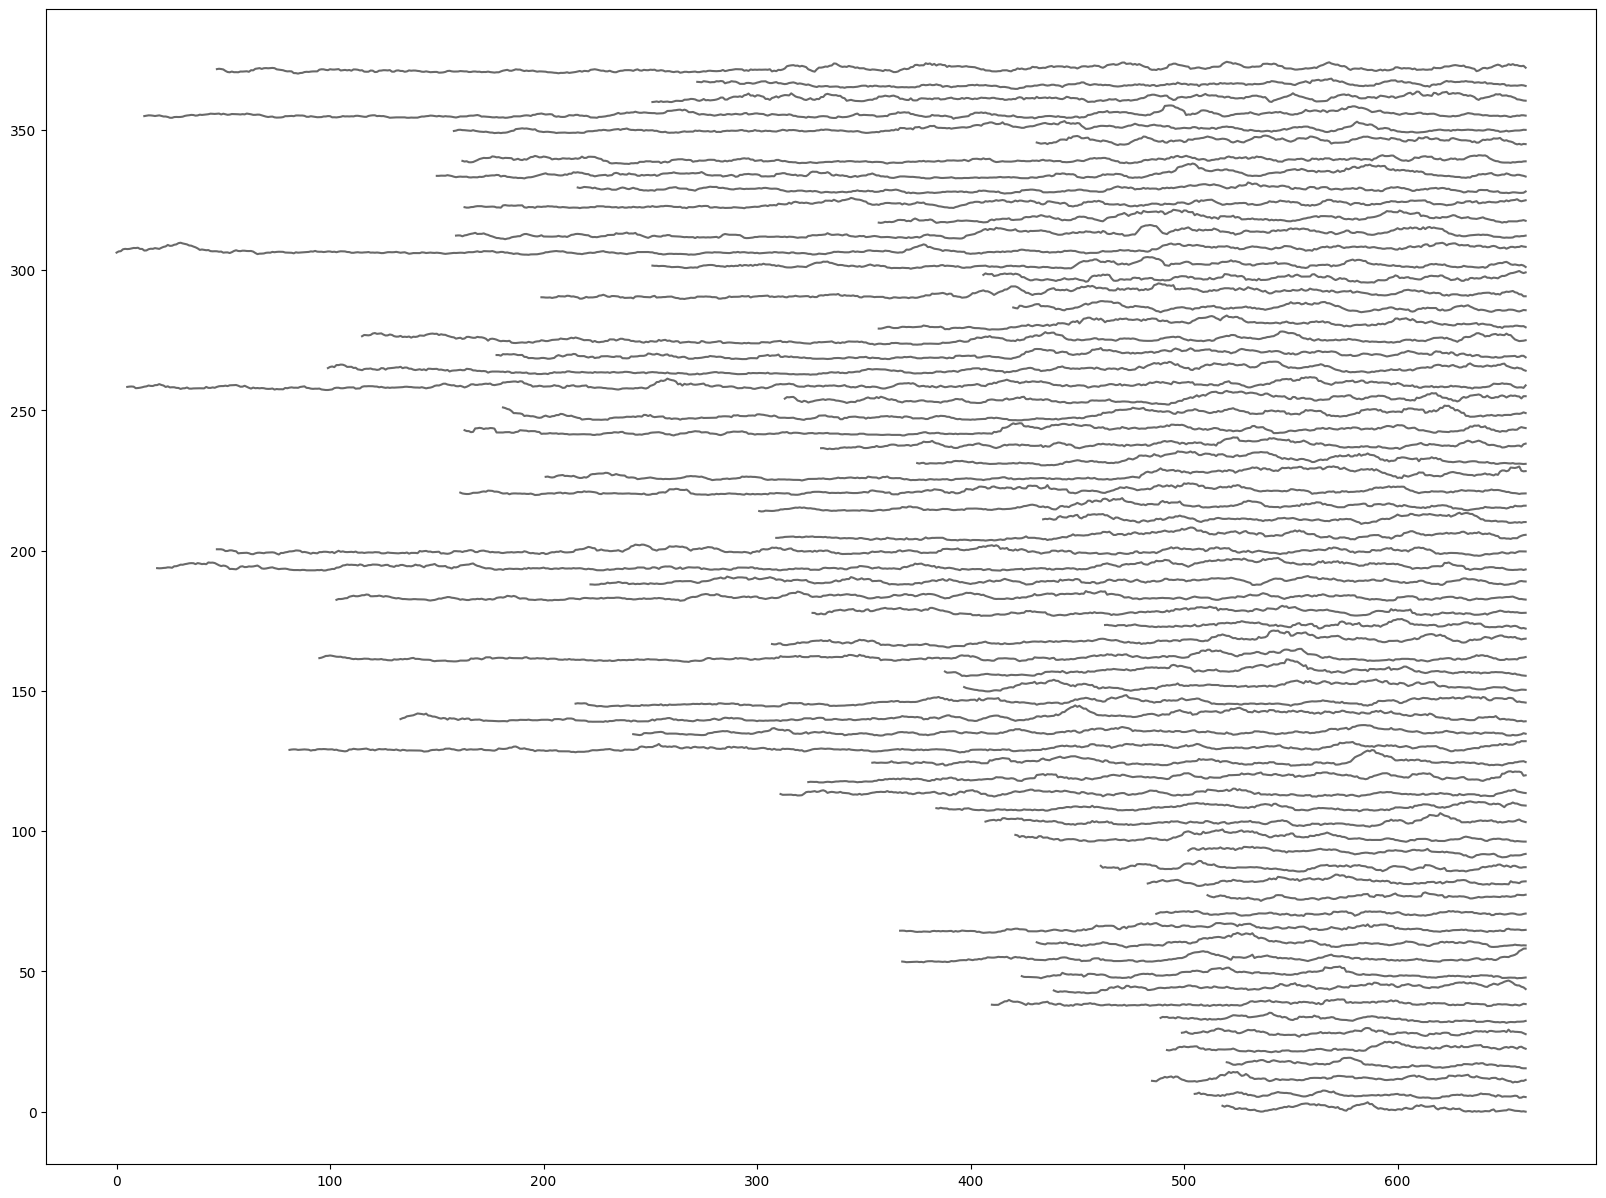

In [112]:
colors = ['g', 'c']*5
i_roi = cn_new_index
original_roi = roi_original_idx.loc[i_roi]
roi_dff_bci_align_thresh = dff_bci_align_thresh[i_roi]
max_act = np.nanmax(roi_dff_bci_align_thresh)
ntrials = roi_dff_bci_align_thresh.shape[0]
roi_dff_bci_align_thresh = roi_dff_bci_align_thresh + np.arange(0, ntrials*max_act, max_act).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(roi_dff_bci_align_thresh[:, :frames_before+100].T, color='dimgrey')

plt.show()

In [100]:
np.nansum(dff_bci_align_thresh)

np.float64(0.0)